#### Load packages

In [16]:
import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from confocalQuant.image import *

from confocalQuant.segmentation import get_czi_files, impose_segmentation
from confocalQuant.data_handling import return_results, load_im_from_memmap, get_meta_vectors

def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        plt[7:10,10:(10+int(end)),i] = 1
  
def get_mean_projections(mat, mask, background_dict, gamma_dict, lower_dict, upper_dict, channels, order, mask_channel, maskit=True, percentile=True, maxproj=False):
    mat_sub = bgrnd_subtract(mat, np.array(list(background_dict.values())))
    if maskit:
        mat_sub_masked = mat_sub.copy()
        for x in mask_channel:
            mat_sub_masked[mask==0,x]=0
            
        if maxproj:
            mat_proj = np.max(mat_sub_masked, axis = (0))
        else:
            mat_proj = np.mean(mat_sub_masked, axis = (0))
    else:
        if maxproj:
            mat_proj = np.max(mat_sub, axis = (0))
        else:
            mat_proj = np.mean(mat_sub, axis = (0))

    mat_g = gamma_correct_image(mat_proj, gamma_dict, lower_dict, upper_dict, is_4D=False, percentile=percentile)
    show = extract_channels(channels, mat_g, is_4D=False)
    show_ordered = show.copy()
    for i in range(show_ordered.shape[-1]):
        show_ordered[:,:,i] = show[:,:,order[i]]
    return show_ordered

#### Load data

In [17]:
df = pd.read_csv('../../new_outs/iNbatch04242024_D54D2_12F4_out//quant_continuous.csv')

out_parent = '../../new_outs/iNbatch04242024_D54D2_12F4_out//'
in_parent = '../../new_data/iNbatch04242024_D54D2_12F4/'
files = get_czi_files(in_parent)

lines, treat = get_meta_vectors(in_parent, files,  '_', '_')
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '../.')

In [18]:
df

,Unnamed: 0,dapi,neun,12F4,D54D2,size,file_ID,mask_ID,file,line,treatment
0,0,0.030581,0.059320,0.001645,0.046479,2039.0,0,1,B02_1.czi,Y622,vehicle
1,1,0.007409,0.096594,0.000654,0.002347,1322.0,0,2,B02_1.czi,Y622,vehicle
2,2,0.039177,0.031786,0.001201,0.005281,2473.0,0,3,B02_1.czi,Y622,vehicle
3,3,0.009909,0.073568,0.002044,0.003719,697.0,0,4,B02_1.czi,Y622,vehicle
4,4,0.032725,0.038590,0.001204,0.039779,2109.0,0,5,B02_1.czi,Y622,vehicle
...,...,...,...,...,...,...,...,...,...,...,...
9114,36,0.075356,0.009965,0.003647,0.044607,160.0,109,37,G11_2.czi,G2,rosiglitazone
9115,37,0.106048,0.009242,0.001968,0.012601,171.0,109,38,G11_2.czi,G2,rosiglitazone
9116,38,0.049763,0.010626,0.001902,0.060551,427.0,109,39,G11_2.czi,G2,rosiglitazone
9117,39,0.054015,0.019009,0.000773,0.008118,190.0,109,40,G11_2.czi,G2,rosiglitazone


#### Identify Rep images

In [4]:
# get rep images
treatments = np.unique(df['treatment'])
dict_treat = dict(zip(df['file'], df['treatment']))
dict_line = dict(zip(df['file'], df['line']))

mean_per_filename, mean_per_condition = compute_avs(df, 'file', 'treatment', 'line', '12F4')

In [5]:
y6 = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
g2 = get_rep_im('vehicle', 'G2', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
e3 = get_rep_im('vehicle', 'E3', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

rep = [g2, y6, e3]

collabs = ['NeuN',  'Ab42']
rowlabs = ['G2', 'Y622', 'E3']

#### Apply image transformations across all conditions

In [6]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,2,3], mat_sele)

nums = [99, 98.9, 97.57 , 99.9] 
upper_dict2 = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

lower_dict = {0: 0, 1: 0, 2: 0, 3: 0}
gamma_dict = {0: 1, 1: 1, 2: 1, 3:1}

nums = [0,95,0,95]
background_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))

percentile=False

#### Choose crop

In [7]:
x1=[260,30, 240]
x2=[360,130, 340]
y1=[270,350, 200]
y2=[370,450, 300]

#### Plot Images

0


//home/gridsan/djuna/homer/github/confocalQuant/confocalQuant/segmentation.py:95: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  res.append(estimate_percentile(matrix, percentile[i], i))


x
1
x
2
x


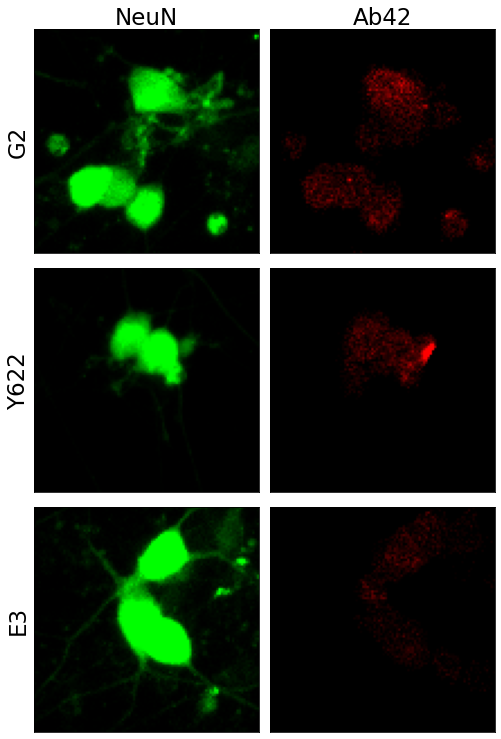

In [12]:
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(8.25, 13))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust the spacing

for i in range(len(rep)):
    print(i)
    ID = conditions[i]
    mask_sele, mat_sele = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,2], mat_sele)

    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict={0:0, 1:95, 2:0 , 3:95}, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict={0:99.5, 1:99.5, 2:99.5 , 3:99.9} , channels=[1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=True, maxproj=False)
    
    plt2 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict2, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile, maxproj=False)
    
    # get image
    imgA = AICSImage(in_parent + files[ID])

    plot_axis(axes, plt1[y1[i]:y2[i],x1[i]:x2[i],:], i,0, 10, imgA, collabs, rowlabs)
    plot_axis(axes, plt2[y1[i]:y2[i],x1[i]:x2[i],:], i,1, 10, imgA, collabs, rowlabs)
        
#fig.savefig('../../out_ims/y622_amyloid_final_e3.png')
